# Recorte 2014 - 2016

In [1]:
# Importando bibliotecas necessárias para a construção de grafos
import netpixi
from netpixi.integration.gt import *
from regression.integration.gt import *
import pandas as pd
import numpy as np
import csv
import ast
import cpnet
from graph_tool import spectral
import seaborn as sns
import regression as reg
import cpnet

from scipy import stats
from matplotlib import pyplot as plt
from graph_tool import centrality
from graph_tool import spectral

<frozen importlib._bootstrap>:914: ImportWarning: VendorImporter.find_spec() not found; falling back to find_module()
/usr/local/lib/python3.10/site-packages/seaborn/rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/usr/local/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
<frozen importlib._bootstrap>:914: ImportWarning: VendorImporter.find_spec() not found; falling back to find_module()
/usr/local/lib/python3.10/site-packages/seaborn/cm.py:1582: PendingDeprecationWarning: The register_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps.register(name)`` instead.
  mpl_cm.register_cmap(_name, _cmap)
/usr/local/lib/python3.10/site-packages/seaborn/cm.py:1583: PendingDeprecationWarning: The register_cmap function will b

In [2]:
df = pd.read_csv('./Video_Games_Sales_as_at_22_Dec_2016.csv')
df.dropna(subset=['Publisher'], inplace=True)
df = df.loc[~df['Critic_Score'].isna() & ~df['User_Score'].isna() & ~df['Rating'].isna()]

In [3]:
df.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8.0,322.0,Nintendo,E
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8.0,192.0,Nintendo,E
6,New Super Mario Bros.,DS,2006.0,Platform,Nintendo,11.28,9.14,6.50,2.88,29.80,89.0,65.0,8.5,431.0,Nintendo,E
7,Wii Play,Wii,2006.0,Misc,Nintendo,13.96,9.18,2.93,2.84,28.92,58.0,41.0,6.6,129.0,Nintendo,E


In [4]:
df_recortado = df.loc[(df['Year_of_Release'] >= 2014) & (df['Year_of_Release'] <= 2016)] 

In [5]:
df_recortado.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
42,Grand Theft Auto V,PS4,2014.0,Action,Take-Two Interactive,3.96,6.31,0.38,1.97,12.61,97.0,66.0,8.3,2899.0,Rockstar North,M
77,FIFA 16,PS4,2015.0,Sports,Electronic Arts,1.12,6.12,0.06,1.28,8.57,82.0,42.0,4.3,896.0,EA Sports,E
92,Call of Duty: Advanced Warfare,PS4,2014.0,Shooter,Activision,2.81,3.48,0.14,1.23,7.66,83.0,39.0,5.7,1443.0,Sledgehammer Games,M
94,FIFA 17,PS4,2016.0,Sports,Electronic Arts,0.66,5.75,0.08,1.11,7.59,85.0,41.0,5.0,398.0,"EA Sports, EA Vancouver",E
105,Fallout 4,PS4,2015.0,Role-Playing,Bethesda Softworks,2.53,3.27,0.24,1.13,7.16,87.0,58.0,6.5,4228.0,Bethesda Game Studios,M


In [6]:
df_recortado.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 676 entries, 42 to 16696
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             676 non-null    object 
 1   Platform         676 non-null    object 
 2   Year_of_Release  676 non-null    float64
 3   Genre            676 non-null    object 
 4   Publisher        676 non-null    object 
 5   NA_Sales         676 non-null    float64
 6   EU_Sales         676 non-null    float64
 7   JP_Sales         676 non-null    float64
 8   Other_Sales      676 non-null    float64
 9   Global_Sales     676 non-null    float64
 10  Critic_Score     676 non-null    float64
 11  Critic_Count     676 non-null    float64
 12  User_Score       676 non-null    float64
 13  User_Count       676 non-null    float64
 14  Developer        676 non-null    object 
 15  Rating           676 non-null    object 
dtypes: float64(10), object(6)
memory usage: 89.8+ KB


In [7]:
df_recortado.Year_of_Release.value_counts()

2014.0    253
2016.0    212
2015.0    211
Name: Year_of_Release, dtype: int64

In [8]:
publishers = df_recortado["Publisher"].unique()

In [9]:
gamergate_graph = Graph(directed=False) # não-dirigido
gamergate_graph.add_vp('Publisher')
gamergate_graph.add_vp('Games_released')
gamergate_graph.add_ep('strength')

for pub in publishers:
    gamergate_graph.add_vertex(pub)
    gamergate_graph.get_vertex(pub)['Publisher'] = pub
    num_games = df_recortado['Name'].loc[df_recortado["Publisher"] == pub].nunique() 
    gamergate_graph.get_vertex(pub)['Games_released'] = num_games

In [10]:
sorted_years = list(range(2014, 2017))
print(sorted_years)

[2014, 2015, 2016]


In [11]:
df_list = []

margem = 4
for i in range(0, len(sorted_years), margem):
    df_list.append(df_recortado[df_recortado['Year_of_Release'].isin(sorted_years[i:i+margem])])

In [12]:
publisher_platforms = []
for db in df_list:
    publisher_platforms.append(db.groupby('Platform')['Publisher'].unique().to_dict())

In [13]:
for platform_dict in publisher_platforms:
    for platform, publishers in platform_dict.items():
        for i in range(len(publishers)):
            if i != len(publishers)-1:
                next_vertex = i+1
                while(next_vertex < len(publishers)):
                    if(publishers[i] != publishers[next_vertex] and not gamergate_graph.has_edge(publishers[i], publishers[next_vertex])):
                        gamergate_graph.add_edge(publishers[i], publishers[next_vertex])
                        gamergate_graph.get_edge(publishers[i], publishers[next_vertex])['strength'] = 1
                        next_vertex += 1
                    else:
                        gamergate_graph.get_edge(publishers[i], publishers[next_vertex])['strength'] += 1
                        next_vertex += 1

In [14]:
print('número de vértices de g:', gamergate_graph.num_vertices())

número de vértices de g: 70


In [15]:
print('número de arestaas de g:', gamergate_graph.num_edges())

número de arestaas de g: 1741


In [16]:
gt_save(gamergate_graph, 'gamergate_graph.net.gz')

In [17]:
g = gt_load('gamergate_graph.net.gz')
g = gt_clean(g)
cc = centrality.closeness(g)
g.add_vp('closeness', cc)
m = gt_draw.sfdp_layout(g)
gt_move(g, m)
gt_save(g, 'gamergate_sfdp.net.gz')

In [18]:
r = netpixi.render('gamergate_sfdp.net.gz', infinite=True);

In [19]:
r.vertex_scale('Games_released', 20, 50)
r.edge_scale('strength', 0.3, 4)
r.vertex_default(color=0xff8674, kscale = 4, bwidth=3, bcolor=0x000000)
r.edge_default(curve1=1, curve2=1)
r.vertex_set_key('Publisher')

In [20]:
r.vertex_scale('closeness', 10, 50)
r.vertex_set_key('Publisher')

# Análise

<AxesSubplot: xlabel='Global_Sales', ylabel='Count'>

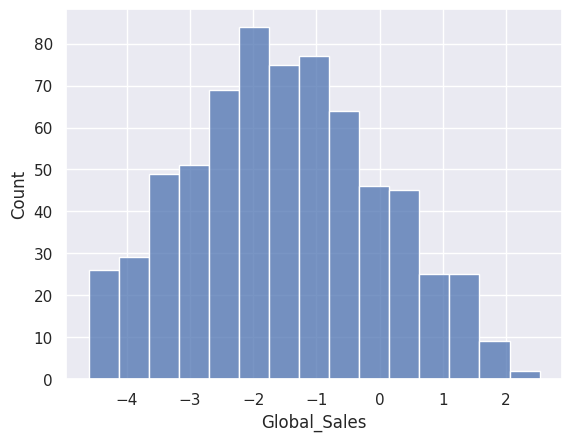

In [21]:
sns.histplot(np.log(df_recortado['Global_Sales']))

# Reconhecimento X Sucesso

In [22]:
df_rec_suc = df_recortado.copy()

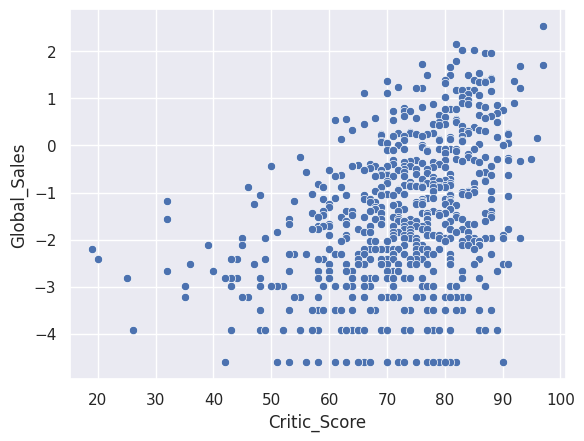

In [23]:
sns.scatterplot(x=df_rec_suc['Critic_Score'], y=np.log(df_rec_suc['Global_Sales']));

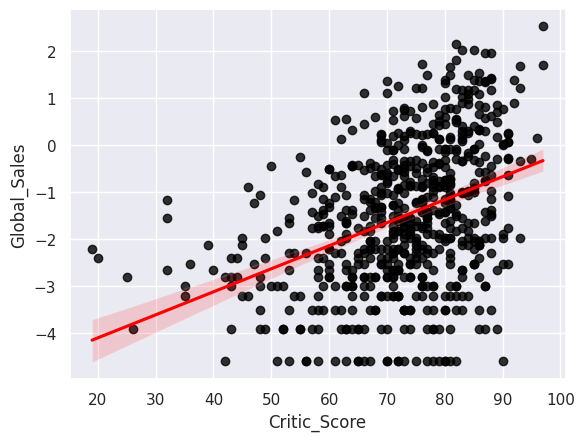

In [24]:
sns.regplot(x=df_rec_suc['Critic_Score'], y=np.log(df_rec_suc['Global_Sales']), scatter_kws={"color": "black"}, line_kws={"color": "red"});

In [25]:
result = reg.linear(data=df_rec_suc, formula='np.log(Global_Sales) ~ Critic_Score')

In [26]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     np.log(Global_Sales)   R-squared:                       0.151
Model:                              OLS   Adj. R-squared:                  0.150
Method:                   Least Squares   F-statistic:                     119.8
Date:                  Tue, 15 Nov 2022   Prob (F-statistic):           8.79e-26
Time:                          15:17:01   Log-Likelihood:                -1190.3
No. Observations:                   676   AIC:                             2385.
Df Residuals:                       674   BIC:                             2394.
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -5.0828      0.330    -15.393      0.000      -5.731      -4.434
Critic_Score     0.0490      0.004     10.947      0.000       0.040       0.058
==============================================================================
Omnibus:                       11.582   Durbin-Watson:                   0.286
Prob(Omnibus):                  0.003   Jarque-Bera (JB):                8.442
Skew:                          -0.160   Prob(JB):                       0.0147
Kurtosis:                       2.556   Cond. No.                         449.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [27]:
result.micro_summary()

variable,coefficient,std error,p-value
Critic_Score,0.049024,0.004478,0.000000


In [28]:
result.nano_summary()

+0.049 (0.004) ***


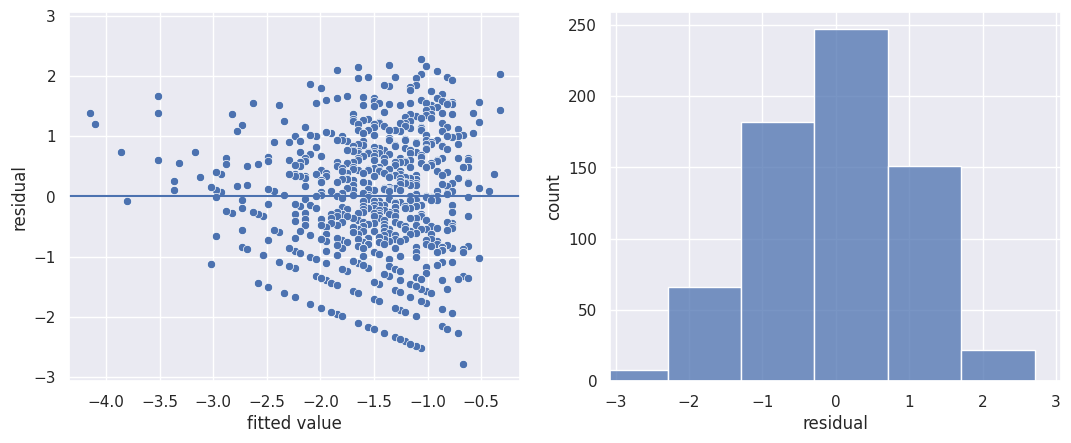

In [29]:
result.plot_residuals()